In [42]:
from configparser import ConfigParser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
config = ConfigParser()
config.read("config.ini", 'UTF-8')

['config.ini']

In [43]:
BTC_PATH = config.get("default", "PATH")

In [47]:
df = pd.read_pickle(BTC_PATH)

# 対数収益率に変換
df['log_return'] = np.log(df['cl']).diff()

# 欠損値処理
df.fillna(method='ffill', inplace=True)

# 学習データとテストデータに分ける
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

C:\Users\sadan\AppData\Local\Temp\ipykernel_22344\3952222.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


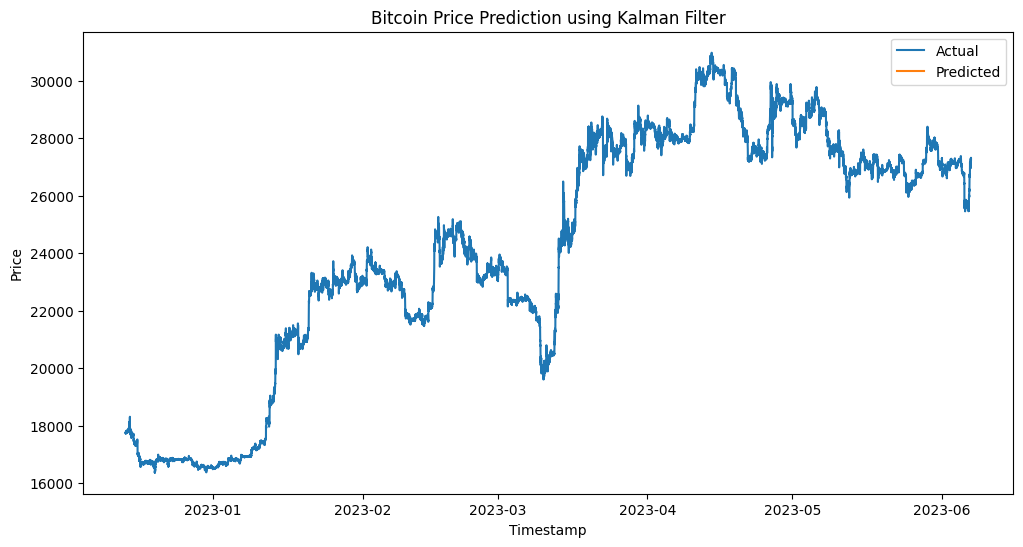

In [70]:
# 欠損値処理 (必要に応じて)
df.fillna(method='ffill', inplace=True)

# 学習データとテストデータの分割
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# カルマンフィルタの設定
kf = KalmanFilter(
    transition_matrices=[[1]],  # 状態遷移行列
    observation_matrices=[[1]],  # 観測行列
    initial_state_mean=0,
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=.01
)

# 学習データを用いたフィルタリング
state_means, state_covariances = kf.filter(train_data['log_return'].values)

# filter_update関数に渡す
predicted_state_means, _ = kf.filter_update(
    filtered_state_mean=state_means[-1,0],
    filtered_state_covariance=state_covariances[-1],
    observation=test_data['log_return'].values
)

# テストデータを用いた予測
predicted_state_means, _ = kf.filter_update(
    filtered_state_mean=state_means[-1,0],
    filtered_state_covariance=state_covariances[-1],
    observation=test_data['log_return'].values
)

# 予測値から実際の価格に戻す
predicted_price = np.exp(np.cumsum(predicted_state_means)) * df['cl'].iloc[train_size-1]

# 結果の可視化
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cl'], label='Actual')
plt.plot(test_data.index, predicted_price, label='Predicted')
plt.legend()
plt.title('Bitcoin Price Prediction using Kalman Filter')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.show()